# Building a model to predict xG in a game using only prior data

Using data from Beat the Bookies (https://beatthebookie.blog/download-excel-files/), I am going to build a model which attempts to predict the xG numbers that a team will put up based on previous data. This will involve team strength, opponent strength, and so on.

We need to output a predicted home xG and a predicted away xG so that this can be fed into the Poisson match outcome model I have made separately.

### Data Collection

Querying the dataset from the SQLite3 database I created, from the data source listed above.

In [24]:
import _sqlite3
import pandas as pd

conn = _sqlite3.connect("data/historic_matches.db")
query = "SELECT * FROM match_data"
df = pd.read_sql_query(query, conn)


### Data Cleaning and Preparation

I need to see how many nulls are in the dataset, I noticed that some data does not have xG or other features that I plan to use in the model so will need to see what to do witht that.

In [25]:
print(df.dtypes)

                         object
division_id              object
division                 object
season_id                object
season                   object
match_date               object
match_teams              object
home_team_id             object
home_team                object
away_team_id             object
away_team                object
home_num_players         object
home_market_value        object
home_avg_market_value    object
away_num_players         object
away_market_value        object
away_avg_market_value    object
home_goals               object
away_goals               object
home_shots               object
away_shots               object
home_shots_on_target     object
away_shots_on_target     object
home_corners             object
away_corners             object
home_yellow              object
away_yellow              object
home_red                 object
away_red                 object
home_xgoals              object
away_xgoals              object
home_dee

I am converting the columns to the correct datatypes.

In [26]:
df["match_date"] = pd.to_datetime(df["match_date"])

num_cols = ["home_num_players", "home_market_value", "home_avg_market_value", "away_num_players", "away_market_value", "away_avg_market_value",
            "home_goals", "away_goals", "home_shots", "away_shots", "home_shots_on_target", "away_shots_on_target", "home_corners", "away_corners",
            "home_red", "away_red", "home_yellow", "away_yellow", "home_xgoals", "away_xgoals", "home_deep", "away_deep", "home_ppda", "away_ppda",
            "bet365_home_odds", "bet365_away_odds", "bet365_draw_odds", "bet365_u25_odds", "bet365_o25_odds"]

for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")


In [27]:
for col in num_cols:
    print(col)
    print(df[col].describe())
    print()

home_num_players
count    42426.000000
mean        28.723966
std          5.279565
min         13.000000
25%         25.000000
50%         28.000000
75%         30.000000
max         73.000000
Name: home_num_players, dtype: float64

home_market_value
count    4.242600e+04
mean     1.215523e+08
std      1.849624e+08
min      3.830000e+06
25%      2.060000e+07
50%      4.625000e+07
75%      1.262500e+08
max      1.300000e+09
Name: home_market_value, dtype: float64

home_avg_market_value
count    4.242600e+04
mean     4.544291e+06
std      7.228586e+06
min      1.541670e+05
25%      7.012785e+05
50%      1.620323e+06
75%      4.641379e+06
max      5.772727e+07
Name: home_avg_market_value, dtype: float64

away_num_players
count    42425.000000
mean        28.727048
std          5.280696
min         13.000000
25%         25.000000
50%         28.000000
75%         30.000000
max         73.000000
Name: away_num_players, dtype: float64

away_market_value
count    4.242500e+04
mean     1.21549

I am going to standardise all the numeric values as there are large differences in the ranges of values. We have average squad value in the millions and then goals in the 0-8 range.

In [28]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

df[num_cols] = scaler.fit_transform(df[num_cols])


I also believe that normalising the dataset so that we have Team and Opponent rather than Home and Away works better, we can also capture the home effect easier this way.

Here I am also going to filter out the features that I am not interested in.

In [49]:
home_df = df[["season", "match_date",
             "home_team", "home_avg_market_value", "home_goals", "home_shots", "home_xgoals", "home_deep", "home_ppda",
             "away_team", "away_avg_market_value", "away_goals", "away_shots", "away_xgoals", "away_deep", "away_ppda"]].copy()
home_df["home?"] = 1

away_df = df[["season", "match_date",
             "away_team", "away_avg_market_value", "away_goals", "away_shots", "away_xgoals", "away_deep", "away_ppda",
             "home_team", "home_avg_market_value", "home_goals", "home_shots", "home_xgoals", "home_deep", "home_ppda"]].copy()
away_df["home?"] = 0

print(home_df.head())

      season match_date           home_team  home_avg_market_value  \
0  2017_2018 2017-07-28              Bochum              -0.558628   
1  2017_2018 2017-07-29           Bielefeld              -0.547503   
2  2017_2018 2017-07-29           Darmstadt              -0.545499   
3  2017_2018 2017-07-31  Fortuna Dusseldorf              -0.561900   
4  2017_2018 2017-08-04      Kaiserslautern              -0.556319   

   home_goals  home_shots  home_xgoals  home_deep  home_ppda       away_team  \
0   -1.184627    0.722506          NaN        NaN        NaN        St Pauli   
1    0.396227    1.113230          NaN        NaN        NaN      Regensburg   
2   -0.394200   -0.645026          NaN        NaN        NaN  Greuther Furth   
3    0.396227    0.136421          NaN        NaN        NaN    Braunschweig   
4   -0.394200   -1.231111          NaN        NaN        NaN       Darmstadt   

   away_avg_market_value  away_goals  away_shots  away_xgoals  away_deep  \
0              -0.5490

### Exploratory Data Analysis

Here we are going to explore the data and see what insights we can gain to aid us in the feature engineering stage.

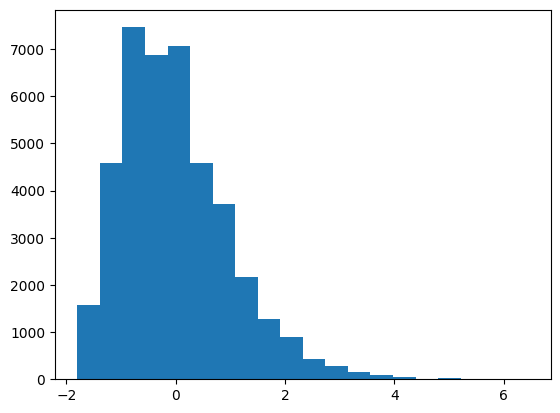

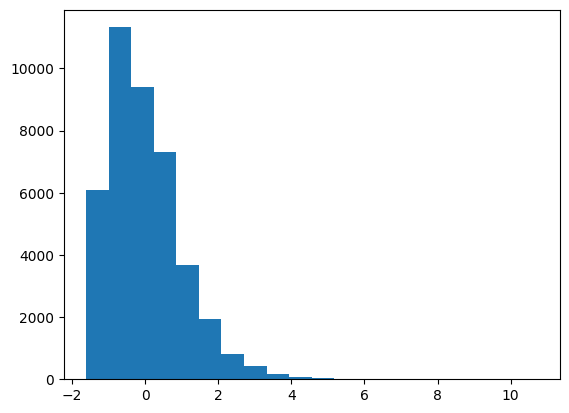

In [50]:
import matplotlib.pyplot as plt

plt.hist(df["home_xgoals"], bins=20)
plt.show()

plt.hist(df["away_xgoals"], bins=20)
plt.show()

Above shows that our target variables both show a right-skew even after normalising them. We may need to transform these so that they show a normal distribution. For now, we will come back to this later.

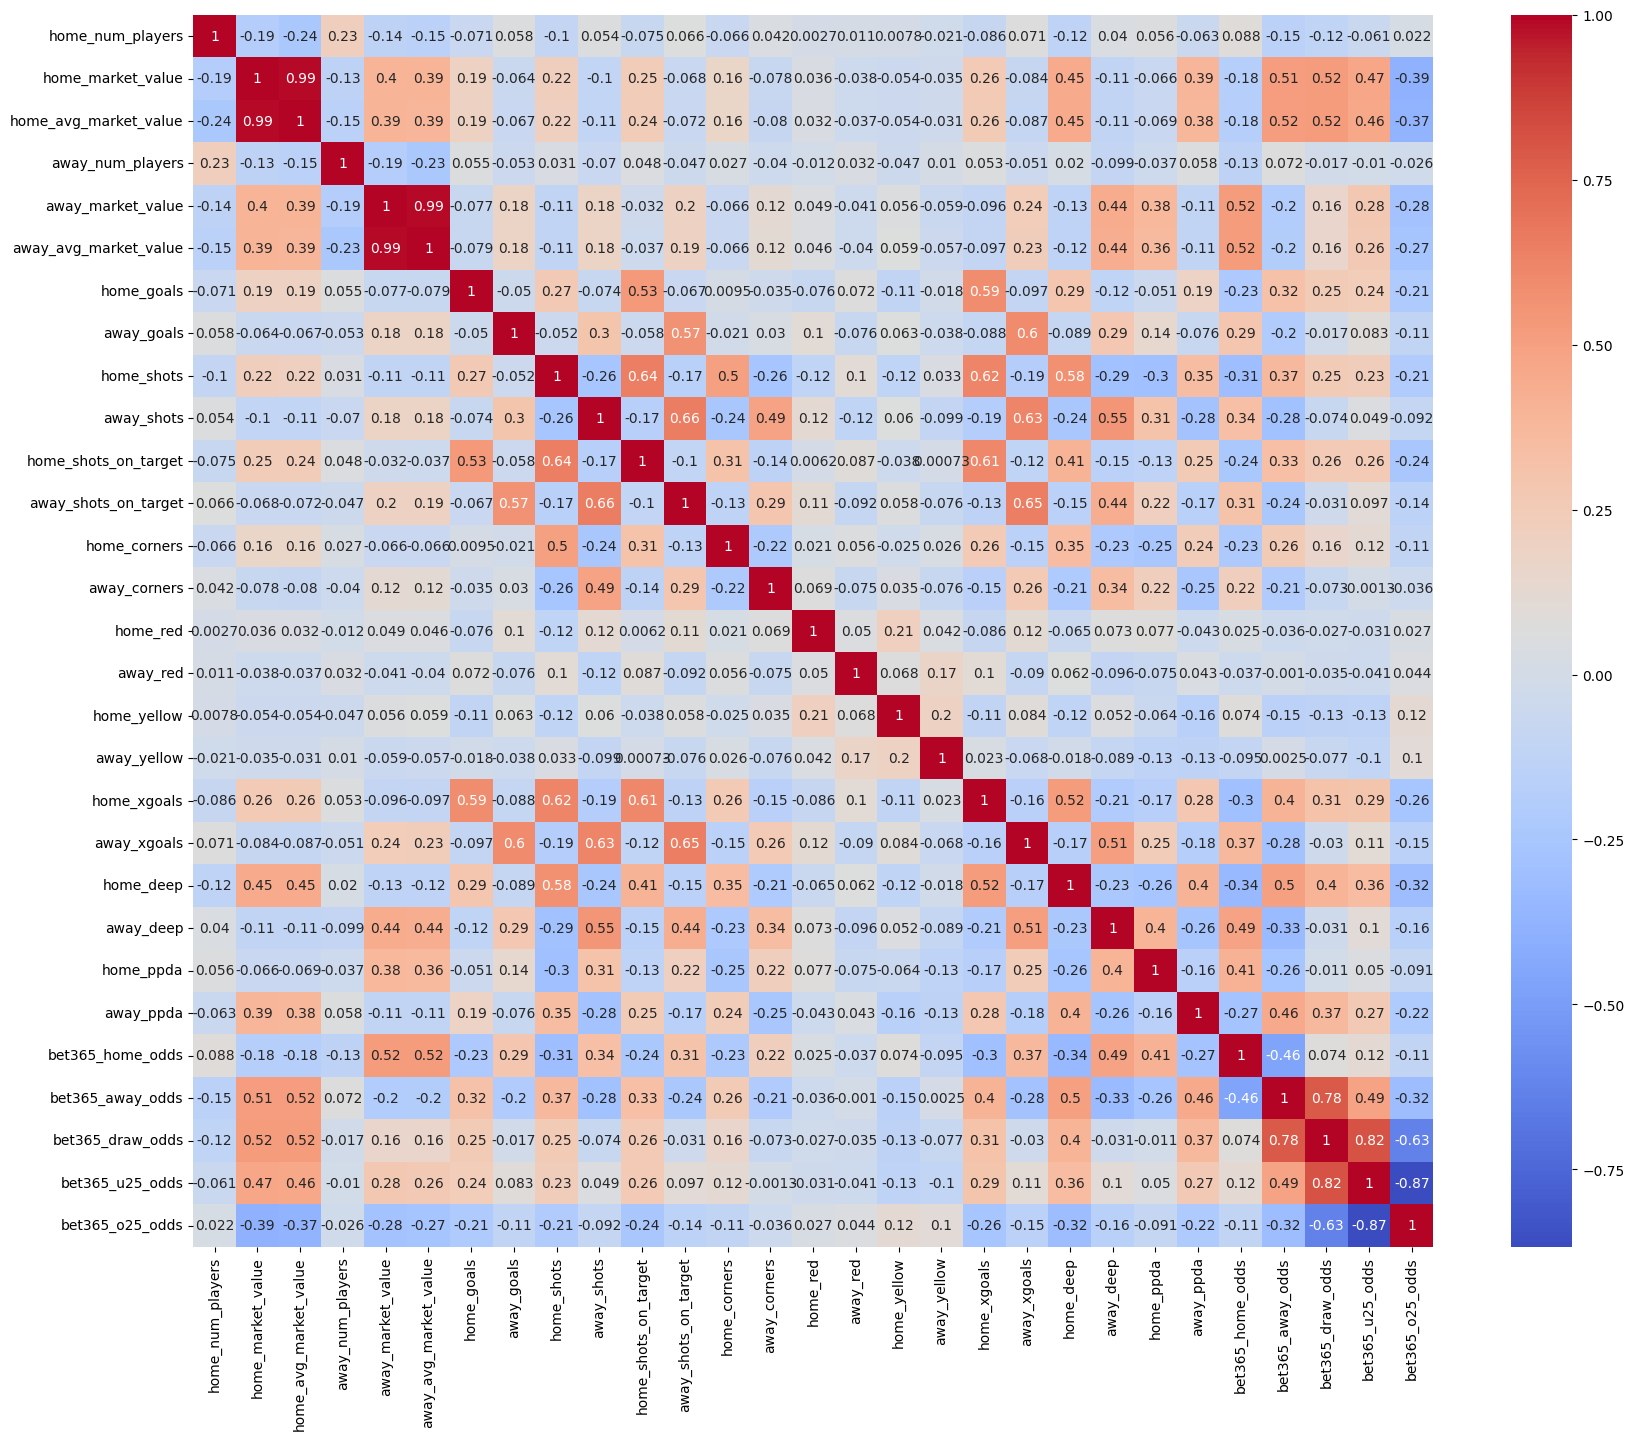

In [51]:
import seaborn as sns

corr_matrix = df[num_cols].corr()

plt.figure(figsize=(20,16))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.show()

### Feature Engineering

For all of the features we plan on creating an exponential moving average that is lagged by one game.